# Wine Quality EDA — Alcohol Regimes and Chemical Drivers

This notebook explores the Wine Quality dataset to:
- identify key chemical drivers associated with `quality`
- test whether alcohol defines structurally distinct regimes (<10%, 10–12%, >12%)
- compare correlations and profiles across regimes to support downstream modeling and risk simulation.


In [1]:
import pandas as pd
import numpy as np
import yaml
from pathlib import Path

# Load project configuration
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

RAW_PATH = Path("..") / config["paths"]["raw_data"]
WINE_QUALITY_FILE = config["files"]["wine_quality"]



In [2]:
wine_quality = pd.read_csv(RAW_PATH / WINE_QUALITY_FILE)

wine_quality.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [3]:
wine_quality.shape


(1143, 13)

In [4]:
wine_quality.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [5]:
wine_quality.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


In [6]:
wine_quality.isna().sum()


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64

In [7]:
wine_quality.duplicated().sum()


np.int64(0)

In [8]:
corr = wine_quality.corr(numeric_only=True)
corr["quality"].sort_values(ascending=False)


quality                 1.000000
alcohol                 0.484866
sulphates               0.257710
citric acid             0.240821
fixed acidity           0.121970
Id                      0.069708
residual sugar          0.022002
pH                     -0.052453
free sulfur dioxide    -0.063260
chlorides              -0.124085
density                -0.175208
total sulfur dioxide   -0.183339
volatile acidity       -0.407394
Name: quality, dtype: float64

In [9]:
# Segmentation variables (defined once for reproducibility)
wine_quality["low_alcohol"] = wine_quality["alcohol"] < 10
wine_quality["alcohol_segment"] = np.where(wine_quality["low_alcohol"], "< 10%", ">= 10%")

wine_quality["alcohol_segment_3"] = pd.cut(
    wine_quality["alcohol"],
    bins=[0, 10, 12, float("inf")],
    labels=["<10%", "10–12%", ">12%"],
    right=False
)


## Alcohol threshold analysis (alcohol < 10%)

This section explores whether wines with alcohol content below 10% exhibit systematically different chemical profiles and quality outcomes.

The objective is to understand whether low-alcohol wines represent a structurally distinct segment rather than noise or outliers.


In [10]:

# Ensure low_alcohol exists
if "low_alcohol" not in wine_quality.columns:
    wine_quality["low_alcohol"] = wine_quality["alcohol"] < 10

wine_quality["alcohol_segment"] = np.where(wine_quality["low_alcohol"], "< 10%", ">= 10%")


In [11]:
wine_quality["low_alcohol"].value_counts(normalize=True)


low_alcohol
False    0.575678
True     0.424322
Name: proportion, dtype: float64

In [12]:
wine_quality.groupby("low_alcohol")["quality"].agg(
    ["count", "mean", "median", "std"]
)


,count,mean,median,std
low_alcohol,,,,
False,658,5.936170,6.0,0.821439
True,485,5.278351,5.0,0.605455


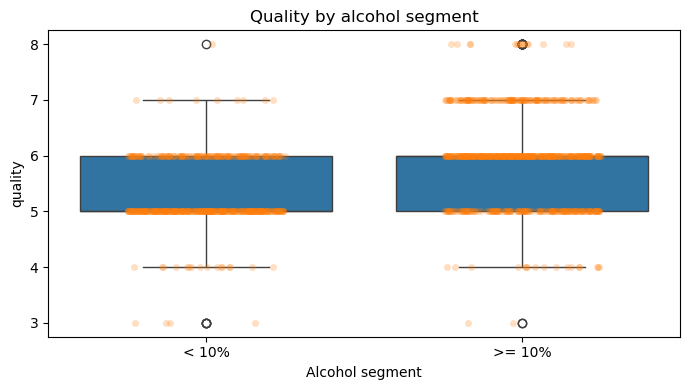

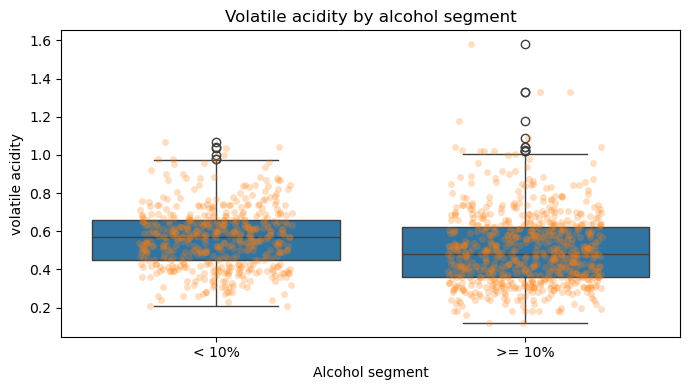

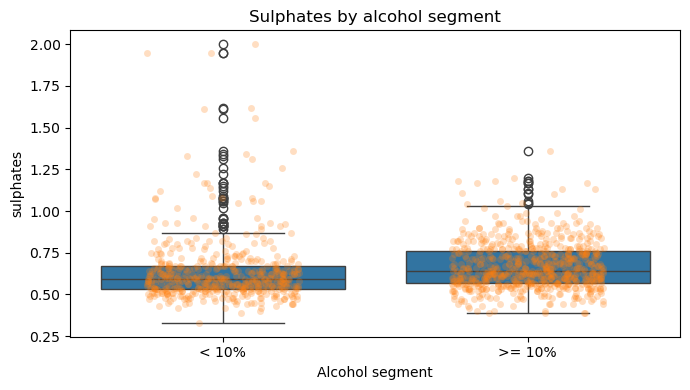

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

def box_with_points(df, y_col, title):
    plt.figure(figsize=(7,4))
    sns.boxplot(data=df, x="alcohol_segment", y=y_col)
    sns.stripplot(data=df, x="alcohol_segment", y=y_col, alpha=0.25, jitter=0.25)
    plt.title(title)
    plt.xlabel("Alcohol segment")
    plt.ylabel(y_col)
    plt.tight_layout()
    plt.show()

box_with_points(wine_quality, "quality", "Quality by alcohol segment")
box_with_points(wine_quality, "volatile acidity", "Volatile acidity by alcohol segment")
box_with_points(wine_quality, "sulphates", "Sulphates by alcohol segment")



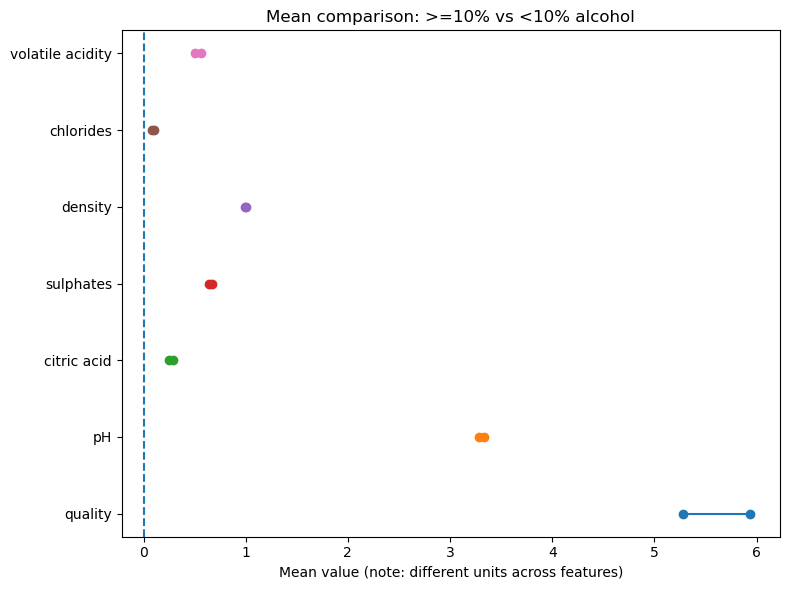

,< 10%,>= 10%,diff_<10_minus_>=10
quality,5.278351,5.936170,-0.657820
pH,3.280969,3.333161,-0.052192
citric acid,0.245320,0.285350,-0.040030
sulphates,0.641010,0.670015,-0.029005
density,0.997437,0.996210,0.001227
chlorides,0.098012,0.078766,0.019246
volatile acidity,0.565454,0.506193,0.059261


In [14]:
features = ["volatile acidity", "sulphates", "chlorides", "pH", "density", "citric acid", "quality"]

means = wine_quality.groupby("alcohol_segment")[features].mean().T
means.columns = ["< 10%", ">= 10%"]
means["diff_<10_minus_>=10"] = means["< 10%"] - means[">= 10%"]

means_sorted = means.sort_values("diff_<10_minus_>=10")

plt.figure(figsize=(8,6))
for i, feat in enumerate(means_sorted.index):
    plt.plot([means_sorted.loc[feat, ">= 10%"], means_sorted.loc[feat, "< 10%"]], [i, i], marker="o")
plt.yticks(range(len(means_sorted.index)), means_sorted.index)
plt.axvline(0, linestyle="--")
plt.title("Mean comparison: >=10% vs <10% alcohol")
plt.xlabel("Mean value (note: different units across features)")
plt.tight_layout()
plt.show()

means_sorted


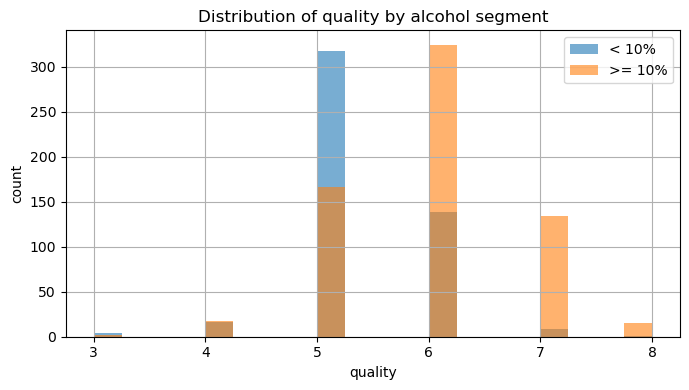

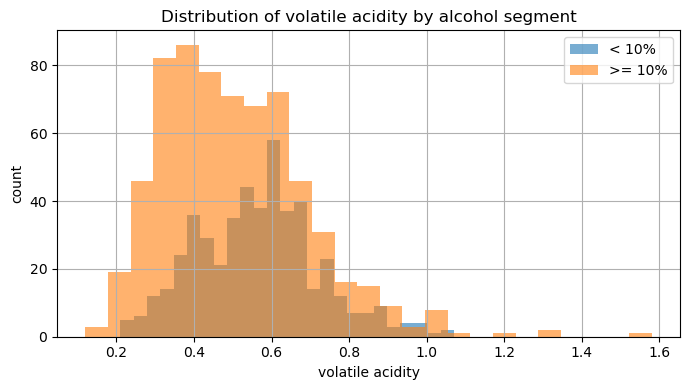

In [16]:
def hist_by_segment(df, col, bins=30):
    plt.figure(figsize=(7,4))
    df[df["alcohol_segment"] == "< 10%"][col].hist(bins=bins, alpha=0.6)
    df[df["alcohol_segment"] == ">= 10%"][col].hist(bins=bins, alpha=0.6)
    plt.title(f"Distribution of {col} by alcohol segment")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.legend(["< 10%", ">= 10%"])
    plt.tight_layout()
    plt.show()

hist_by_segment(wine_quality, "quality", bins=20)
hist_by_segment(wine_quality, "volatile acidity", bins=25)



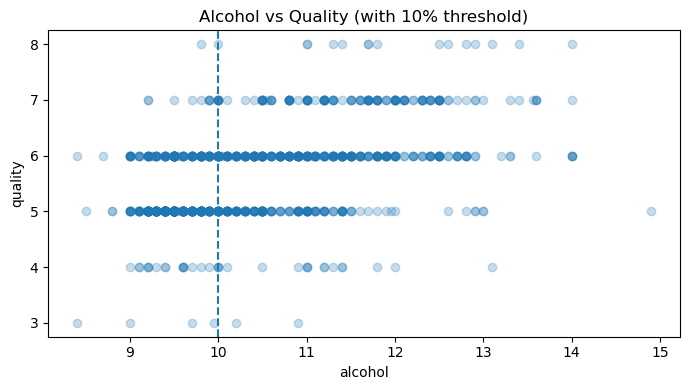

In [17]:
plt.figure(figsize=(7,4))
plt.scatter(wine_quality["alcohol"], wine_quality["quality"], alpha=0.25)
plt.axvline(10, linestyle="--")
plt.title("Alcohol vs Quality (with 10% threshold)")
plt.xlabel("alcohol")
plt.ylabel("quality")
plt.tight_layout()
plt.show()


The scatter plot shows a clear structural change around the 10% alcohol threshold. Wines below this level exhibit a narrow quality range, while higher-quality wines only appear above 10%. This supports using 10% alcohol as a meaningful analytical cutoff rather than an arbitrary split.



## Alcohol segmentation analysis (<10%, 10–12%, >12%)

This section extends the alcohol threshold analysis by splitting wines into three alcohol ranges
to assess how chemical composition and quality evolve across segments.


In [20]:
import numpy as np

wine_quality["alcohol_segment_3"] = pd.cut(
    wine_quality["alcohol"],
    bins=[0, 10, 12, np.inf],
    labels=["<10%", "10–12%", ">12%"],
    right=False
)

wine_quality["alcohol_segment_3"].value_counts()


alcohol_segment_3
10–12%    536
<10%      485
>12%      122
Name: count, dtype: int64

In [21]:
wine_quality.groupby("alcohol_segment_3")["quality"].agg(
    ["count", "mean", "median", "std"]
)


C:\Users\Marta\AppData\Local\Temp\ipykernel_20888\1265984070.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wine_quality.groupby("alcohol_segment_3")["quality"].agg(


,count,mean,median,std
alcohol_segment_3,,,,
<10%,485,5.278351,5.0,0.605455
10–12%,536,5.824627,6.0,0.791916
>12%,122,6.426230,6.0,0.770511


In [22]:
features = [
    "quality",
    "volatile acidity",
    "sulphates",
    "chlorides",
    "density",
    "pH",
    "citric acid"
]

segment_means = wine_quality.groupby("alcohol_segment_3")[features].mean()
segment_means


C:\Users\Marta\AppData\Local\Temp\ipykernel_20888\3081071344.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_means = wine_quality.groupby("alcohol_segment_3")[features].mean()


,quality,volatile acidity,sulphates,chlorides,density,pH,citric acid
alcohol_segment_3,,,,,,,
<10%,5.278351,0.565454,0.641010,0.098012,0.997437,3.280969,0.245320
10–12%,5.824627,0.519496,0.665746,0.080735,0.996559,3.324608,0.276642
>12%,6.426230,0.447746,0.688770,0.070115,0.994674,3.370738,0.323607


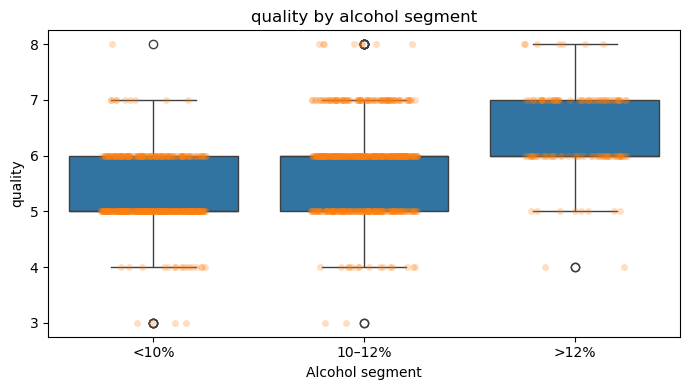

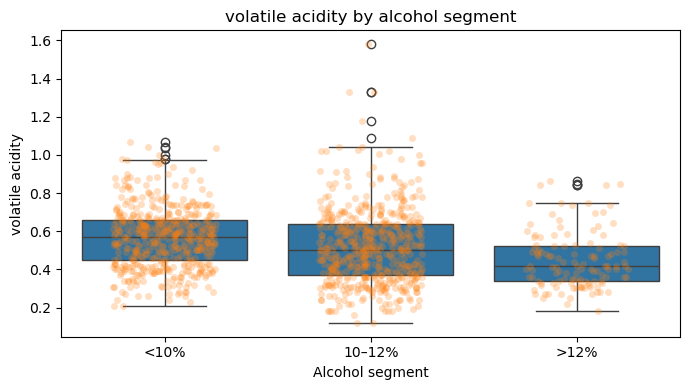

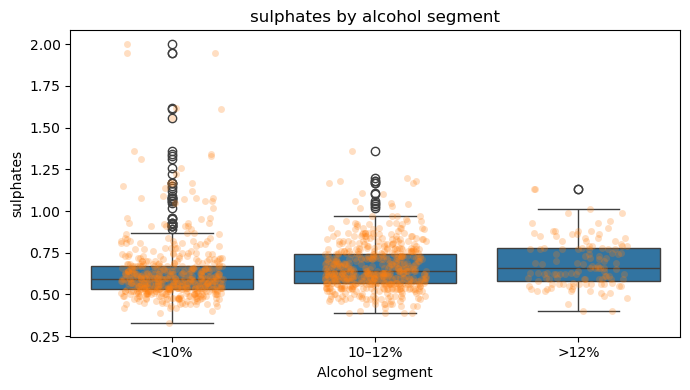

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

def box_by_segment(df, y_col):
    plt.figure(figsize=(7,4))
    sns.boxplot(
        data=df,
        x="alcohol_segment_3",
        y=y_col,
        order=["<10%", "10–12%", ">12%"]
    )
    sns.stripplot(
        data=df,
        x="alcohol_segment_3",
        y=y_col,
        order=["<10%", "10–12%", ">12%"],
        alpha=0.25,
        jitter=0.25
    )
    plt.title(f"{y_col} by alcohol segment")
    plt.xlabel("Alcohol segment")
    plt.ylabel(y_col)
    plt.tight_layout()
    plt.show()

for col in ["quality", "volatile acidity", "sulphates"]:
    box_by_segment(wine_quality, col)


In [24]:
# Differences relative to the middle segment (10–12%)
baseline = segment_means.loc["10–12%"]

diff_table = segment_means.subtract(baseline)
diff_table


,quality,volatile acidity,sulphates,chlorides,density,pH,citric acid
alcohol_segment_3,,,,,,,
<10%,-0.546276,0.045957,-0.024736,0.017277,0.000877,-0.043639,-0.031322
10–12%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
>12%,0.601603,-0.071750,0.023024,-0.010620,-0.001885,0.046129,0.046965


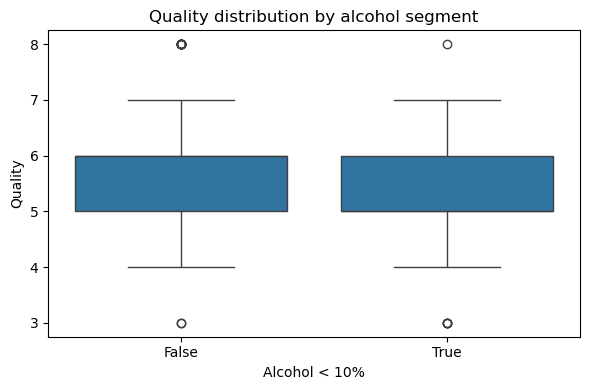

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.boxplot(
    x="low_alcohol",
    y="quality",
    data=wine_quality
)
plt.xlabel("Alcohol < 10%")
plt.ylabel("Quality")
plt.title("Quality distribution by alcohol segment")
plt.tight_layout()
plt.show()


In [26]:
key_features = [
    "volatile acidity",
    "sulphates",
    "chlorides",
    "pH",
    "density",
    "citric acid"
]

wine_quality.groupby("low_alcohol")[key_features].mean()


,volatile acidity,sulphates,chlorides,pH,density,citric acid
low_alcohol,,,,,,
False,0.506193,0.670015,0.078766,3.333161,0.996210,0.28535
True,0.565454,0.641010,0.098012,3.280969,0.997437,0.24532


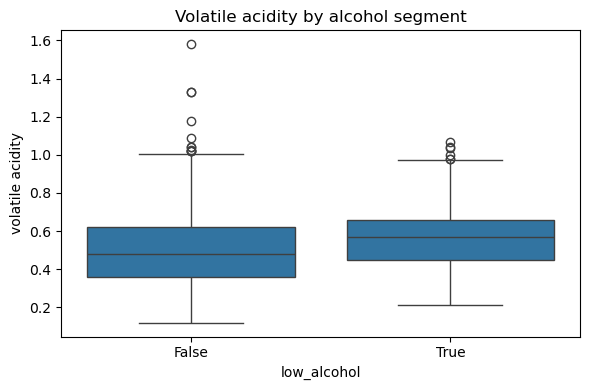

In [27]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    x="low_alcohol",
    y="volatile acidity",
    data=wine_quality
)
plt.title("Volatile acidity by alcohol segment")
plt.tight_layout()
plt.show()


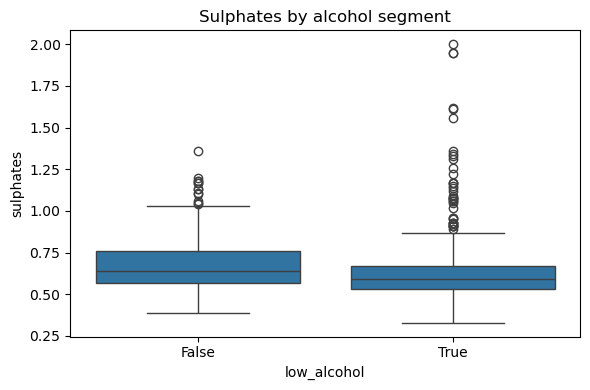

In [28]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    x="low_alcohol",
    y="sulphates",
    data=wine_quality
)
plt.title("Sulphates by alcohol segment")
plt.tight_layout()
plt.show()


In [29]:
# Select only numeric columns for correlation
numeric_cols = wine_quality.select_dtypes(include="number").columns

low_corr = (
    wine_quality[wine_quality["low_alcohol"]][numeric_cols]
    .corr()["quality"]
)

high_corr = (
    wine_quality[~wine_quality["low_alcohol"]][numeric_cols]
    .corr()["quality"]
)

corr_comparison = pd.DataFrame({
    "low_alcohol": low_corr,
    "high_alcohol": high_corr
}).sort_values(by="low_alcohol")

corr_comparison


,low_alcohol,high_alcohol
volatile acidity,-0.307380,-0.411154
total sulfur dioxide,-0.162889,-0.050377
free sulfur dioxide,-0.150054,0.016832
pH,-0.043492,-0.180852
chlorides,-0.020898,-0.109043
Id,-0.019677,-0.035218
residual sugar,-0.017947,0.024928
density,0.050742,-0.095178
citric acid,0.092702,0.283804
alcohol,0.130303,0.344584


## Alcohol range segmentation and correlation analysis

This section analyzes how the relationship between key chemical parameters and wine quality
changes across alcohol ranges (<10%, 10–12%, >12%).

The objective is to identify whether alcohol level modulates the impact of other variables on quality.


In [30]:
if "Id" in wine_quality.columns:
    wine_quality = wine_quality.drop(columns=["Id"])


In [31]:
wine_quality["alcohol_segment_3"] = pd.cut(
    wine_quality["alcohol"],
    bins=[0, 10, 12, float("inf")],
    labels=["<10%", "10–12%", ">12%"],
    right=False
)


In [32]:
features_of_interest = [
    "total sulfur dioxide",
    "free sulfur dioxide",
    "residual sugar",
    "volatile acidity",
    "fixed acidity",
    "pH"
]


In [33]:
corr_by_segment = {}

for segment in ["<10%", "10–12%", ">12%"]:
    df_seg = wine_quality[wine_quality["alcohol_segment_3"] == segment]
    corr = df_seg[features_of_interest + ["quality"]].corr(method="pearson")["quality"]
    corr_by_segment[segment] = corr

corr_table = pd.DataFrame(corr_by_segment).loc[features_of_interest]
corr_table


,<10%,10–12%,>12%
total sulfur dioxide,-0.162889,-0.108464,0.047416
free sulfur dioxide,-0.150054,0.027575,-0.008900
residual sugar,-0.017947,-0.036552,0.042393
volatile acidity,-0.307380,-0.423187,-0.197174
fixed acidity,0.140055,0.191145,0.091556
pH,-0.043492,-0.242285,-0.181379


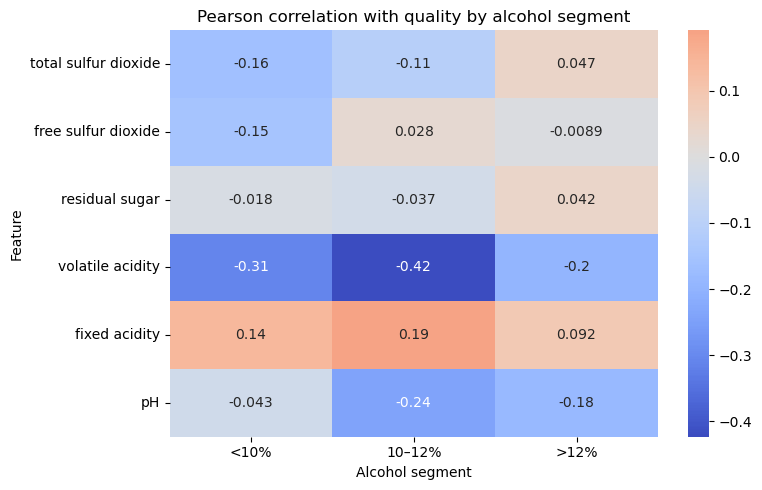

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.heatmap(
    corr_table,
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title("Pearson correlation with quality by alcohol segment")
plt.xlabel("Alcohol segment")
plt.ylabel("Feature")
plt.tight_layout()
# Save BEFORE show (important)
plt.savefig("pearson_corr_quality_by_alcohol_segment.png", dpi=300, bbox_inches="tight")
plt.show()

In [35]:
for segment in ["<10%", "10–12%", ">12%"]:
    corr = wine_quality[
        wine_quality["alcohol_segment_3"] == segment
    ][["alcohol", "quality"]].corr().iloc[0,1]
    
    print(f"{segment}: corr(alcohol, quality) = {corr:.3f}")


<10%: corr(alcohol, quality) = 0.130
10–12%: corr(alcohol, quality) = 0.259
>12%: corr(alcohol, quality) = -0.047


In [36]:
corr_table.head()

,<10%,10–12%,>12%
total sulfur dioxide,-0.162889,-0.108464,0.047416
free sulfur dioxide,-0.150054,0.027575,-0.008900
residual sugar,-0.017947,-0.036552,0.042393
volatile acidity,-0.307380,-0.423187,-0.197174
fixed acidity,0.140055,0.191145,0.091556
